In [1]:
from random import random, randint, choice, choices, uniform
from typing import Union
from dataclasses import dataclass, astuple
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class CardDeck():

    def __init__(self) -> None:
        self.cards = [2, 3, 4, 5, 6, 7, 8, 9, 10, 'A', 'J', 'Q', 'K']

    def draw_card(self) -> Union[int, str]: #returns an integer or a string

        # Randomly selecting an item
        return choices(self.cards, weights = [4/52] * len(self.cards))[0]

In [3]:
class Agent():

      def __init__(self, policy = None) -> None:
          self.sum = 0
          self.ace = False
          self.policy = policy

      def get_ace(self) -> bool:
          return self.ace

In [4]:
@dataclass
class State():
    """The state of a Blackjack game"""
    def __init__(self, player_sum: int, dealer_sum: int) -> None:
        self.player_sum = player_sum
        self.dealer_sum = dealer_sum

    def get_state(self) -> tuple[int, int]:
        return self.player_sum, self.dealer_sum


In [5]:
class Game():

      def random_state(self) -> State:
          """Generate a random state (to begin the first half of the game)."""
          player_sum = randint(2, 20)
          if player_sum >= 11:
              r = random()
              if r >= 0.5:
                  self.player.ace = True
              else:
                  self.player.ace = False
          else:
              self.player.ace = False

          dealer_sum = randint(2, 11)
          if dealer_sum == 11:
              self.dealer.ace = True
          else:
              self.dealer.ace = False


          self.player.sum = player_sum
          self.dealer.sum = dealer_sum

          return State(player_sum, dealer_sum)

      def __init__(self, deck : CardDeck, player: Agent, dealer: Agent, init_state: State | None = None, init_action_player: str | None = None, init_action_dealer: str | None = None) -> None:  #ukini ovaj init_state
          """
            init_action_player = str - "HIT", "HOLD", "RANDOM"
                                 None - the initial action is determined by the agent's policy
          """
          self.deck = deck
          self.player = player
          self.dealer = dealer
          self.player_sequence = []
          self.dealer_sequence = []

          self.init_state = init_state

          if self.init_state == None:
              self.state = self.random_state()
          else: #iskreno ovaj slucaj me jako nervira 28.12. zbog keca npr
              self.state = self.init_state
              self.player.sum = self.state.player_sum
              self.dealer.sum = self.dealer.sum

          self.init_action_player = init_action_player #mozda zelim i da spec da li je random ili po politici ##ovaj kom mi sad nema smisla 28.12.
          self.init_action_dealer = init_action_dealer

      def reinitialize_game(self):
          if self.init_state == None:
              self.state = self.random_state()
          else:
              self.state = self.init_state
              self.player.sum = self.state.player_sum
              self.dealer.sum = self.dealer.sum

          self.player_sequence = []
          self.dealer_sequence = []

      def random_action(self) -> str:
          r = random()
          if r >= 0.5:
              return "HIT"
          else:
              return "HOLD"

      def hit(self, agent: Agent) -> None:
          card = self.deck.draw_card()
          if card == 'A':
              if agent.sum + 11 > 21:
                  agent.sum += 1
              else:
                  agent.ace = True
                  agent.sum += 11
          elif card in ['J', 'Q', 'K']:
              if agent.sum + 10 <= 21:
                  agent.sum += 10
              else:
                  if agent.ace == False:
                      agent.sum += 10
                  else:
                      agent.ace = False
          else:
              if agent.sum + card <= 21:
                  agent.sum += card
              else:
                  if agent.ace == True:
                      agent.sum -= 10
                      agent.sum += card
                      agent.ace = False
                  else:
                      agent.sum += card

      def hold(self, agent) -> int:
          return agent.sum

      def next_action(self, agent: Agent, state: tuple[int, int]) -> str:
          if agent.policy == None:
              return self.random_action()
          elif (state, agent.ace) not in agent.policy:
              return self.random_action()
          else:
              return agent.policy[(state, agent.ace)]

      def player_hit(self, agent: Agent) -> None:
          self.player_sequence.append((self.state.get_state(), agent.get_ace(), "HIT"))
          self.hit(agent)
          self.state.player_sum = agent.sum

      def dealer_hit(self, agent: Agent) -> None:
          self.dealer_sequence.append((self.state.get_state(), agent.get_ace(), "HIT"))
          self.hit(agent)
          self.state.dealer_sum = agent.sum

      def play_one_turn(self, agent: Agent, init_action: str | None = None) -> int:
          """
              Represents one playthrough (sequence of moves) by the agent

              agent = player/dealer
              init_action = the initial aciton of the agent.
                            str - "HIT", "HOLD", "RANDOM"
                            None - the initial action is determined by the agents policy

              returns the total sum of the agent at the end of the sequence of moves
          """
          hold = False

          if init_action == "RANDOM":
              init_action = self.random_action()
          if init_action == "HIT":
              if agent == self.player:
                  self.player_hit(agent)
              else:
                  self.dealer_hit(agent)

              if agent.sum >= 21:
                      #self.player_sequence.append(agent.sum) #samo da vidim koja je suma ako je bust ili BJ
                      return agent.sum
          elif init_action == "HOLD":
              if agent == self.player:
                  self.player_sequence.append((self.state.get_state(), agent.get_ace(), "HOLD"))
              else:
                  self.dealer_sequence.append((self.state.get_state(), agent.get_ace(), "HOLD"))
              return self.hold(agent)

          while True:
              action = self.next_action(agent, self.state.get_state())

              if action == "HOLD":
                  if agent == self.player:
                      self.player_sequence.append((self.state.get_state(), agent.get_ace(), "HOLD"))
                  else:
                      self.dealer_sequence.append((self.state.get_state(), agent.get_ace(), "HOLD"))
                  return self.hold(agent)

              else:
                  if agent == self.player:
                      self.player_hit(agent)
                  else:
                      self.dealer_hit(agent)

                  if agent.sum >= 21:
                      """if agent == self.player: #isto za bust/BJ
                          self.player_sequence.append(agent.sum)
                      else:
                          self.dealer_sequence.append(agent.sum)"""
                      return agent.sum

      def play_one_game(self) -> tuple[list[tuple[tuple[int, int], bool, str], list[tuple[tuple[int, int], bool, str]]], int]:
          """
              Represents one game. The first to play is the player. The second (if the player didn't bust or score blackjack = 21) is the dealer.

              The method returns player's, and dealer's sequences of moves, and the outcome of the game:
                - 1 if the player won
                - 0 if it's a tie
                - 2 if the dealer won
          """

          player_score = self.play_one_turn(self.player, self.init_action_player)
          if player_score > 21:
              return self.player_sequence, self.dealer_sequence, 2
          elif player_score == 21: #mozda problematicno ##mislim da nije 28.12.
              return self.player_sequence, self.dealer_sequence, 1

          dealer_score = self.play_one_turn(self.dealer, self.init_action_dealer)
          if dealer_score > 21:
              return self.player_sequence, self.dealer_sequence, 1
          elif dealer_score == 21: #mozda problematicno ##nije 2.1.
              return self.player_sequence, self.dealer_sequence, 2
          elif player_score > dealer_score:
              return self.player_sequence, self.dealer_sequence, 1
          elif player_score < dealer_score:
              return self.player_sequence, self.dealer_sequence, 2
          else:
              return self.player_sequence, self.dealer_sequence, 0

      def initialize_second_part(self) -> State:
          """Generate a random state (to begin the second part of the game)."""
          self.player_sequence = []
          self.dealer_sequence = []
          player_sum = randint(2, 20)
          if player_sum >= 11:
              r = random()
              if r >= 0.5:
                  self.player.ace = True
              else:
                  self.player.ace = False
          else:
              self.player.ace = False

          dealer_sum = randint(2, 11)

          self.player_sequence.append(((player_sum, dealer_sum), self.player.ace, "HOLD"))

          dealer_sum_new = randint(12, 20)
          if (dealer_sum != 11 and (dealer_sum + 11 < dealer_sum_new)) or dealer_sum == 11 and dealer_sum_new != 12:
              r = random()
              if r >= 0.5:
                  self.dealer.ace = True
              else:
                  self.dealer.ace = False
          elif dealer_sum == 11 and dealer_sum_new == 12: #dodao 6.1.
              self.dealer.ace = True
          else:
              self.dealer.ace = False

          self.player.sum = player_sum
          self.dealer.sum = dealer_sum_new

          return State(player_sum, dealer_sum_new)

      def play_second_part(self):

          self.state = self.initialize_second_part()
          player_score = self.player.sum

          dealer_score = self.play_one_turn(self.dealer, self.init_action_dealer)
          if dealer_score > 21:
              return self.player_sequence, self.dealer_sequence, 1
          elif dealer_score == 21:
              return self.player_sequence, self.dealer_sequence, 2
          elif player_score > dealer_score:
              return self.player_sequence, self.dealer_sequence, 1
          elif player_score < dealer_score:
              return self.player_sequence, self.dealer_sequence, 2
          else:
              return self.player_sequence, self.dealer_sequence, 0

      ### Q-Learning, SARSA methods


In [53]:
class Environment():
    def __init__(self, gamma: float, deck: CardDeck, player: Agent, dealer: Agent, init_state: State | None = None, init_action_player: str | None = None, init_action_dealer: str | None = None) -> None:
        self.gamma = gamma
        self.deck = deck
        self.player = player
        self.dealer = dealer
        self.init_state = init_state
        self.init_action_player = init_action_player
        self.init_action_dealer = init_action_dealer
        self.game = Game(self.deck, self.player, self.dealer, self.init_state, self.init_action_player, self.init_action_dealer)
        self.player_experience = dict()
        self.dealer_experience = dict()
        self.Q_player = dict()
        self.Q_dealer = dict()

    def generate_rewards(self, final_reward: float, rewards_num: int) -> list[float]:
        return [0]*(rewards_num-1) + [final_reward]

    def compute_gain(self, rewards: list[float], gamma: float) -> float:
        """
        Compute the total gain given the list of future rewards.

        Args:
            rewards (list[float]): List of future rewards.
            gamma: discount factor

        Return:
            float: The total gain
        """
        g = 0
        w = 1
        for r in rewards:
            g += w*r
            w *= gamma
        return g

    def discounted_gains(self, rewards: list[float], gamma: float) -> list[float]:
        """
        Compute list of discounted gains, given a sequence of rewards.

        Args:
            rewards (list[float]): Sequence of rewards.
            gamma: discount factor

        Return:
            list[float]: sequence of gains
        """
        gains = [self.compute_gain(rewards[i:], gamma) for i in range(len(rewards))]
        return gains

    def evaluate_gains(self, outcome: int, player_moves_num: int, dealer_moves_num: int) -> tuple[list[float], list[float]]:
        if outcome == 1:
            if dealer_moves_num == 0: #player has gotten a blackjack
                player_gains = self.discounted_gains(self.generate_rewards(1, player_moves_num), self.gamma)
                dealer_gains = []
            else:
                player_gains = self.discounted_gains(self.generate_rewards(1, player_moves_num), self.gamma)
                dealer_gains = self.discounted_gains(self.generate_rewards(-1, dealer_moves_num), self.gamma)
        if outcome == 0:
            player_gains = self.generate_rewards(0, player_moves_num)
            dealer_gains = self.generate_rewards(0, dealer_moves_num)
        if outcome == 2:
            if dealer_moves_num == 0: #player has busted
                player_gains = self.discounted_gains(self.generate_rewards(-1, player_moves_num), self.gamma)
                dealer_gains = []
            else:
                player_gains = self.discounted_gains(self.generate_rewards(-1, player_moves_num), self.gamma)
                dealer_gains = self.discounted_gains(self.generate_rewards(1, dealer_moves_num), self.gamma)
        return player_gains, dealer_gains

    def update_experience_player(self, state: tuple[tuple[int, int], bool], action: str, gain: float) -> None:
        if action == "HIT":
            if state not in self.player_experience:
                self.player_experience[state] = [[gain], []]
            else:
                self.player_experience[state][0].append(gain)
        else:
            if state not in self.player_experience:
                self.player_experience[state] = [[], [gain]]
            else:
                self.player_experience[state][1].append(gain)

    def update_experience_dealer(self, state: tuple[tuple[int, int], bool], action: str, gain: float) -> None:
        if action == "HIT":
            if state not in self.dealer_experience:
                self.dealer_experience[state] = [[gain], []]
            else:
                self.dealer_experience[state][0].append(gain)
        else:
            if state not in self.dealer_experience:
                self.dealer_experience[state] = [[], [gain]]
            else:
                self.dealer_experience[state][1].append(gain)

    def play_one_game(self, start: int) -> int:
        if start == 1:
            self.game.reinitialize_game()
            player_sequence, dealer_sequence, outcome = self.game.play_one_game()
        else:
            player_sequence, dealer_sequence, outcome = self.game.play_second_part()

        player_gains, dealer_gains = self.evaluate_gains(outcome, len(player_sequence), len(dealer_sequence))

        for i in range(len(player_sequence)):
            self.update_experience_player((player_sequence[i][0], player_sequence[i][1]), player_sequence[i][2], player_gains[i])
        if dealer_gains != []:
            for i in range(len(dealer_sequence)):
                self.update_experience_dealer((dealer_sequence[i][0], dealer_sequence[i][1]), dealer_sequence[i][2], dealer_gains[i])

        return outcome

    def play_N_games(self, N: int, start: int) -> tuple[int, int, int, int, int]:
        player_wins = 0
        draws = 0
        dealer_wins = 0
        for _ in range (N):
            outcome = self.play_one_game(start)
            if outcome == 1:
                player_wins += 1
            elif outcome == 0:
                draws += 1
            else:
                dealer_wins += 1
        return player_wins, draws, dealer_wins

    def compute_average_gains(self, agent: Agent) -> dict[tuple[tuple[int, int], bool], list[float, float]]:                #ovde sam za slucaj da nema te akcije tj nije skupio eksp tj nikada u tom stanju nije odigrao akciju
        result = dict()                                                                                                     #promenio da umesto 0 Q bude -1 3.1.
        if agent == self.player:
            for state in self.player_experience:
                if len(self.player_experience[state][0]) == 0 and len(self.player_experience[state][1]) == 0:
                    result[state] = [-1, -1]
                elif len(self.player_experience[state][0]) == 0:
                    result[state] = [-1, sum(self.player_experience[state][1])/len(self.player_experience[state][1])]
                elif len(self.player_experience[state][1]) == 0:
                    result[state] = [sum(self.player_experience[state][0])/len(self.player_experience[state][0]), -1]
                else:
                    result[state] = [sum(self.player_experience[state][0])/len(self.player_experience[state][0]), sum(self.player_experience[state][1])/len(self.player_experience[state][1])]
        if agent == self.dealer:
            for state in self.dealer_experience:
                if len(self.dealer_experience[state][0]) == 0 and len(self.dealer_experience[state][1]) == 0:
                    result[state] = [-1, -1]
                elif len(self.dealer_experience[state][0]) == 0:
                    result[state] = [-1, sum(self.dealer_experience[state][1])/len(self.dealer_experience[state][1])]
                elif len(self.dealer_experience[state][1]) == 0:
                    result[state] = [sum(self.dealer_experience[state][0])/len(self.dealer_experience[state][0]), -1]
                else:
                    result[state] = [sum(self.dealer_experience[state][0])/len(self.dealer_experience[state][0]), sum(self.dealer_experience[state][1])/len(self.dealer_experience[state][1])]
        return result

    def update_Q_player(self) -> None:
        Q_player = self.compute_average_gains(self.player)
        sorted_Q_player = dict(sorted(Q_player.items(), key=lambda item: (item[0][0][0], item[0][0][1])))
        self.Q_player = sorted_Q_player

    def update_Q_dealer(self) -> None:
        Q_dealer = self.compute_average_gains(self.dealer)
        sorted_Q_dealer = dict(sorted(Q_dealer.items(), key=lambda item: (item[0][0][0], item[0][0][1])))
        self.Q_dealer = sorted_Q_dealer

    def greedy_policy(self, agent: Agent) -> dict[tuple[tuple[int, int], bool], str]:
        policy = dict()
        if agent == self.player:
            for state in self.Q_player:
                maximum = max(self.Q_player[state])
                if self.Q_player[state].index(maximum) == 0:
                    policy[state] = "HIT"
                else:
                    policy[state] = "HOLD"
        else:
            for state in self.Q_dealer:
                maximum = max(self.Q_dealer[state])
                if self.Q_dealer[state].index(maximum) == 0:
                    policy[state] = "HIT"
                else:
                    policy[state] = "HOLD"
        return policy

    def naive_monte_carlo(self, N: int, T: int) -> tuple[dict[tuple[tuple[int, int], bool], str], dict[tuple[tuple[int, int], bool], str]]:

        player_policy = dict()
        dealer_policy = dict()
        best_player_policy = None
        best_dealer_policy = None
        player_losses = []
        dealer_losses = []
        player_losses_validation = []
        dealer_losses_validation = []

        for i in range(T):
            self.player_experience = dict()
            self.dealer_experience = dict()
            results1 = self.play_N_games(N, 1)
            results2 = self.play_N_games(N, 2)

            results = [x + y for x, y in zip(results1, results2)]
            player_score = results[0]-results[2]
            dealer_score = -player_score

            player_losses.append(player_score/(2*N))
            dealer_losses.append(dealer_score/(2*N))

            self.update_Q_player()
            self.update_Q_dealer()

            self.player.policy = self.greedy_policy(self.player)
            self.dealer.policy = self.greedy_policy(self.dealer) ### ovo zakomentarisati ako zelimo da dealer igra po fiksnoj classic politici

            ### VALIDATION

            self.game.init_action_player = None #initial action is not exploratory, but follows the policy
            self.game.init_action_dealer = None
            results_validation1 = self.play_N_games(N, 1)
            results_validation2 = self.play_N_games(N, 2)

            results_validation = [x + y for x, y in zip(results_validation1, results_validation2)]
            player_score_validation = results_validation[0]-results_validation[2]
            dealer_score_validation  = -player_score_validation

            player_losses_validation.append(player_score_validation/(2*N))
            dealer_losses_validation.append(dealer_score_validation/(2*N))

            if best_player_policy == None or player_score_validation > best_player_result:
                best_player_policy = self.player.policy
                best_player_result = player_score_validation

            if best_dealer_policy == None or dealer_score_validation > best_dealer_result:
                best_dealer_policy = self.dealer.policy
                best_dealer_result = dealer_score_validation

            self.game.init_action_player = self.init_action_player
            self.game.init_action_dealer = self.init_action_dealer

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
        ax1.plot(player_losses, label="player_losses")
        ax1.plot(player_losses_validation, label="player_losses_validation")
        ax1.set_title('Player losses')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(dealer_losses, label="dealer_losses")
        ax2.plot(dealer_losses_validation, label="dealer_losses_validation")
        ax2.set_title('Dealer losses')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()

        return best_player_policy, best_dealer_policy

    def update_Q_value_IMC(self, current: float, target: float, alpha: float) -> float:
        """Update the given current estimate given the new target.

        Args:
            current (float): existing estimate
            target (float): the given target
            alpha (float): learning rate

        Return:
            float: the new, updated estimate
        """
        if current is None:
            return target
        else:
            return current + alpha * (target - current)

    def update_Q_IMC(self,agent: Agent, alpha=0.1) -> None:
        """Update Q-function based on the experience."""
        if agent == self.player:
            gains = self.compute_average_gains(self.player)
        else:
            gains = self.compute_average_gains(self.dealer)

        for state in gains:

            target_value_HIT = gains[state][0]
            target_value_HOLD = gains[state][1]
            if agent == self.player:
                old_values = self.Q_player.get(state, [None, None])      #6.1. videcemo mozda ne radi ovako
            else:
                old_values = self.Q_dealer.get(state, [None, None])
            old_value_HIT, old_value_HOLD = old_values
            q_value_HIT = self.update_Q_value_IMC(old_value_HIT, target_value_HIT, alpha)
            q_value_HOLD = self.update_Q_value_IMC(old_value_HOLD, target_value_HOLD, alpha)
            if agent == self.player:
                self.Q_player[state] = [q_value_HIT, q_value_HOLD]
            else:
                self.Q_dealer[state] = [q_value_HIT, q_value_HOLD]

            """if agent == self.dealer and state == ((2,3), False):
              print("izracunati avg gains za ((2,3), False) ", gains[((2,3), False)])
              print("target hit",target_value_HIT)
              print("target hold", target_value_HOLD)
              print("old hit", old_value_HIT)
              print("old hold", old_value_HIT)
              print("izracunate vrednosti koje ce se upisati u Q za ((2,3), False) ", [q_value_HIT, q_value_HOLD])
              print(((2,3), False), self.Q_dealer[((2,3), False)])"""

        if agent == self.player:
            self.Q_player = dict(sorted(self.Q_player.items(), key=lambda item: (item[0][0][0], item[0][0][1])))
        else:
            self.Q_dealer = dict(sorted(self.Q_dealer.items(), key=lambda item: (item[0][0][0], item[0][0][1])))

    def incremental_monte_carlo(self, N: int, T: int, alpha: float = 0.1) -> tuple[dict[tuple[tuple[int, int], bool], str], dict[tuple[tuple[int, int], bool], str]]:

        self.player_experience = dict()
        self.dealer_experience = dict()
        self.Q_dealer = dict() ### 6.1. posto sam prvo radio obican pa da ocisti ali bolje je samo kada se testira da se napravi novi env
        self.Q_player = dict()
        self.dealer.policy = None
        self.player.policy = None ###
        player_policy = dict()
        dealer_policy = dict()
        best_player_policy = None
        best_dealer_policy = None
        player_losses = []
        dealer_losses = []
        player_losses_validation = []
        dealer_losses_validation = []

        for i in range(T):
            self.player_experience = dict()
            self.dealer_experience = dict()
            results1 = self.play_N_games(N, 1)
            results2 = self.play_N_games(N, 2)

            results = [x + y for x, y in zip(results1, results2)]
            player_score = results[0]-results[2]
            dealer_score = -player_score

            player_losses.append(player_score/(2*N))
            dealer_losses.append(dealer_score/(2*N))

            self.update_Q_IMC(self.player, alpha)
            self.update_Q_IMC(self.dealer, alpha)

            self.player.policy = self.greedy_policy(self.player)
            self.dealer.policy = self.greedy_policy(self.dealer) ### ovo zakomentarisati ako zelimo da dealer igra po fiksnoj classic politici

            ### VALIDATION

            self.game.init_action_player = None #initial action is not exploratory, but follows the policy
            self.game.init_action_dealer = None
            results_validation1 = self.play_N_games(N, 1)
            results_validation2 = self.play_N_games(N, 2)

            results_validation = [x + y for x, y in zip(results_validation1, results_validation2)]
            player_score_validation = results_validation[0]-results_validation[2]
            dealer_score_validation  = -player_score_validation

            player_losses_validation.append(player_score_validation/(2*N))
            dealer_losses_validation.append(dealer_score_validation/(2*N))

            if best_player_policy == None or player_score_validation > best_player_result:
                best_player_policy = self.player.policy
                best_player_result = player_score_validation

            if best_dealer_policy == None or dealer_score_validation > best_dealer_result:
                best_dealer_policy = self.dealer.policy
                best_dealer_result = dealer_score_validation

            self.game.init_action_player = self.init_action_player
            self.game.init_action_dealer = self.init_action_dealer

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
        ax1.plot(player_losses, label="player_losses")
        ax1.plot(player_losses_validation, label="player_losses_validation")
        ax1.set_title('Player losses')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(dealer_losses, label="dealer_losses")
        ax2.plot(dealer_losses_validation, label="dealer_losses_validation")
        ax2.set_title('Dealer losses')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()

        return best_player_policy, best_dealer_policy

    def initialize_Q_player(self) -> dict[tuple[tuple[int, int], bool], list[float]]:
        Q = dict()
        for i in range(2,21):
            for j in range(2,12):
                if i >= 11:
                    Q[((i, j), True)] = [uniform(-1,1), uniform(-1,1)]
                Q[((i, j), False)] = [uniform(-1,1), uniform(-1,1)]
        return dict(sorted(Q.items(), key=lambda item: (item[0][0][0], item[0][0][1])))

    def initialize_Q_dealer(self) -> dict[tuple[tuple[int, int], bool], list[float]]:
        Q = dict()
        for i in range(2,21):
            for j in range(2,21):
                if j >= 11:
                    Q[((i, j), True)] = [uniform(-1,1), uniform(-1,1)]
                Q[((i, j), False)] = [uniform(-1,1), uniform(-1,1)]
        return dict(sorted(Q.items(), key=lambda item: (item[0][0][0], item[0][0][1])))

    def epsilon_greedy(self, epsilon: float, Q: dict[tuple[tuple[int, int], bool], list[float]], state: tuple[tuple[int, int], bool]) -> str:
        r = random()
        if r > epsilon: #proveri
            return self.game.random_action()
        else:
            if Q[state].index(max(Q[state])) == 0:
                return "HIT"
            else:
                return "HOLD"

    def Q_learning(self, N: int, gamma: float, alpha: float, epsilon: float) -> tuple[dict[tuple[tuple[int, int], bool], str], dict[tuple[tuple[int, int], bool], str]]:
        self.Q_player = self.initialize_Q_player() #initialize Q
        self.Q_dealer = self.initialize_Q_dealer()

        for i in range(N):
            self.game.reinitialize_game() #initialize S
            state_player = (self.game.state.get_state(), self.player.ace)
            while True: #one episode (game) starting from the first half of the game
                action_player = self.epsilon_greedy(epsilon, self.Q_player, state_player) #choose A from S using epsilon-greedy derrived from Q
                if action_player == "HIT": #take action A, and observe S+ and R
                    self.game.hit(self.player)
                    self.game.state.player_sum = self.player.sum                                        #8.1. dodao
                    state_player_next = (self.game.state.get_state(), self.player.ace)
                    if self.player.sum == 21:
                        reward_player = 1
                    elif self.player.sum > 21:
                        reward_player = -1
                    else:
                        reward_player = 0

                    if reward_player == -1 or reward_player == 1:
                        self.Q_player[state_player][0] = self.Q_player[state_player][0] + alpha*(reward_player - self.Q_player[state_player][0])
                    else:
                        self.Q_player[state_player][0] = self.Q_player[state_player][0] + alpha*(reward_player + gamma*max(self.Q_player[state_player_next]) - self.Q_player[state_player][0]) #update Q(s,a)
                    state_player = state_player_next
                    if reward_player == 1 or reward_player == -1: #if S = terminal break
                        break
                else: #PLAYER HOLD
                    state_dealer = (self.game.state.get_state(), self.dealer.ace)
                    while True: #DEALERS TURN
                        action_dealer = self.epsilon_greedy(epsilon, self.Q_dealer, state_dealer) #choose A from S using epsilon-greedy derrived from Q
                        if action_dealer == "HIT": #take action A, and observe S+ and R
                            self.game.hit(self.dealer)
                            self.game.state.dealer_sum = self.dealer.sum                                        #8.1. dodao
                            state_dealer_next = (self.game.state.get_state(), self.dealer.ace)
                            if self.dealer.sum == 21:
                                reward_dealer = 1
                            elif self.dealer.sum > 21:
                                reward_dealer = -1
                            else:
                                reward_dealer = 0

                            if reward_dealer == -1 or reward_dealer == 1:
                                self.Q_dealer[state_dealer][0] = self.Q_dealer[state_dealer][0] + alpha*(reward_dealer - self.Q_dealer[state_dealer][0])
                            else:
                                self.Q_dealer[state_dealer][0] = self.Q_dealer[state_dealer][0] + alpha*(reward_dealer + gamma*max(self.Q_dealer[state_dealer_next]) - self.Q_dealer[state_dealer][0]) #update Q(s,a)
                            state_dealer = state_dealer_next
                            if reward_dealer == 1: #if S = terminal break
                                reward_player = -1
                                self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                                break
                            elif reward_dealer == -1: #if S = terminal break
                                reward_player = 1
                                self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                                break
                        else: #DEALER HOLD
                            if self.player.sum > self.dealer.sum:
                                reward_player = 1
                                self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                                reward_dealer = -1
                                self.Q_dealer[state_dealer][1] = self.Q_dealer[state_dealer][1] + alpha*(reward_dealer - self.Q_dealer[state_dealer][1])
                            elif self.player.sum < self.dealer.sum:
                                reward_player = -1
                                self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                                reward_dealer = 1
                                self.Q_dealer[state_dealer][1] = self.Q_dealer[state_dealer][1] + alpha*(reward_dealer - self.Q_dealer[state_dealer][1])
                            else:
                                reward_player = 0
                                self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                                reward_dealer = 0
                                self.Q_dealer[state_dealer][1] = self.Q_dealer[state_dealer][1] + alpha*(reward_dealer - self.Q_dealer[state_dealer][1])
                            break#bio je za dva taba desno jos
                    break

            self.game.state = self.game.initialize_second_part() #initialize S.
            state_player = (self.game.player_sequence[0][0], self.player.ace)
            state_dealer = (self.game.state.get_state(), self.dealer.ace)
            while True: #DEALERS TURN
                action_dealer = self.epsilon_greedy(epsilon, self.Q_dealer, state_dealer) #choose A from S using epsilon-greedy derrived from Q
                if action_dealer == "HIT": #take action A, and observe S+ and R
                    self.game.hit(self.dealer)
                    self.game.state.dealer_sum = self.dealer.sum                                        #8.1. dodao
                    state_dealer_next = (self.game.state.get_state(), self.dealer.ace)
                    if self.dealer.sum == 21:
                        reward_dealer = 1
                    elif self.dealer.sum > 21:
                        reward_dealer = -1
                    else:
                        reward_dealer = 0

                    if reward_dealer == -1 or reward_dealer == 1:
                        self.Q_dealer[state_dealer][0] = self.Q_dealer[state_dealer][0] + alpha*(reward_dealer - self.Q_dealer[state_dealer][0])
                    else:
                        self.Q_dealer[state_dealer][0] = self.Q_dealer[state_dealer][0] + alpha*(reward_dealer + gamma*max(self.Q_dealer[state_dealer_next]) - self.Q_dealer[state_dealer][0]) #update Q(s,a)
                    state_dealer = state_dealer_next
                    if reward_dealer == 1: #if S = terminal break
                        reward_player = -1
                        self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                        break
                    elif reward_dealer == -1: #if S = terminal break
                        reward_player = 1
                        self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                        break
                else: #DEALER HOLD
                    if self.player.sum > self.dealer.sum:
                        reward_player = 1
                        self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                        reward_dealer = -1
                        self.Q_dealer[state_dealer][1] = self.Q_dealer[state_dealer][1] + alpha*(reward_dealer - self.Q_dealer[state_dealer][1])
                    elif self.player.sum < self.dealer.sum:
                        reward_player = -1
                        self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                        reward_dealer = 1
                        self.Q_dealer[state_dealer][1] = self.Q_dealer[state_dealer][1] + alpha*(reward_dealer - self.Q_dealer[state_dealer][1])
                    else:
                        reward_player = 0
                        self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                        reward_dealer = 0
                        self.Q_dealer[state_dealer][1] = self.Q_dealer[state_dealer][1] + alpha*(reward_dealer - self.Q_dealer[state_dealer][1])
                    break ### ->

        return self.greedy_policy(self.player), self.greedy_policy(self.dealer)

    def sarsa(self, N: int, gamma: float, alpha: float, epsilon: float) -> tuple[dict[tuple[tuple[int, int], bool], str], dict[tuple[tuple[int, int], bool], str]]:
        self.Q_player = self.initialize_Q_player() #initialize Q
        self.Q_dealer = self.initialize_Q_dealer()

        for i in range(N):
            self.game.reinitialize_game() #initialize S
            state_player = (self.game.state.get_state(), self.player.ace)
            action_player = self.epsilon_greedy(epsilon, self.Q_player, state_player) #choose A from S using epsilon-greedy derrived from Q
            while True: #one episode (game) starting from the first half of the game
                if action_player == "HIT": #take action A, and observe S+ and R
                    self.game.hit(self.player)
                    self.game.state.player_sum = self.player.sum                                        #8.1. dodao
                    state_player_next = (self.game.state.get_state(), self.player.ace)
                    if self.player.sum == 21:
                        reward_player = 1
                    elif self.player.sum > 21:
                        reward_player = -1
                    else:
                        reward_player = 0

                    if reward_player == 0:
                        action_player_next = self.epsilon_greedy(epsilon, self.Q_player, state_player_next) #choose A+ from S+ using epsilon-greedy derrived from Q

                    if reward_player == -1 or reward_player == 1:
                        self.Q_player[state_player][0] = self.Q_player[state_player][0] + alpha*(reward_player - self.Q_player[state_player][0])
                    else:
                        if action_player_next == "HIT":
                            self.Q_player[state_player][0] = self.Q_player[state_player][0] + alpha*(reward_player + gamma*self.Q_player[state_player_next][0] - self.Q_player[state_player][0]) #update Q(s,a)
                        else:
                            self.Q_player[state_player][0] = self.Q_player[state_player][0] + alpha*(reward_player + gamma*self.Q_player[state_player_next][1] - self.Q_player[state_player][0]) #update Q(s,a)
                    state_player = state_player_next
                    action_player = action_player_next
                    if reward_player == 1 or reward_player == -1: #if S = terminal break
                        break
                else: #PLAYER HOLD
                    state_dealer = (self.game.state.get_state(), self.dealer.ace)
                    action_dealer = self.epsilon_greedy(epsilon, self.Q_dealer, state_dealer) #choose A from S using epsilon-greedy derrived from Q
                    while True: #DEALERS TURN
                        if action_dealer == "HIT": #take action A, and observe S+ and R
                            self.game.hit(self.dealer)
                            self.game.state.dealer_sum = self.dealer.sum                                        #8.1. dodao
                            state_dealer_next = (self.game.state.get_state(), self.dealer.ace)
                            if self.dealer.sum == 21:
                                reward_dealer = 1
                            elif self.dealer.sum > 21:
                                reward_dealer = -1
                            else:
                                reward_dealer = 0

                            if reward_dealer == 0:
                                action_dealer_next = self.epsilon_greedy(epsilon, self.Q_dealer, state_dealer_next) #choose A+ from S+ using epsilon-greedy derrived from Q

                            if reward_dealer == -1 or reward_dealer == 1:
                                self.Q_dealer[state_dealer][0] = self.Q_dealer[state_dealer][0] + alpha*(reward_dealer - self.Q_dealer[state_dealer][0])
                            else:
                                if state_dealer_next == "HIT":
                                    self.Q_dealer[state_dealer][0] = self.Q_dealer[state_dealer][0] + alpha*(reward_dealer + gamma*self.Q_dealer[state_dealer_next][0] - self.Q_dealer[state_dealer][0]) #update Q(s,a)
                                else:
                                    self.Q_dealer[state_dealer][0] = self.Q_dealer[state_dealer][0] + alpha*(reward_dealer + gamma*self.Q_dealer[state_dealer_next][1] - self.Q_dealer[state_dealer][0]) #update Q(s,a)
                            state_dealer = state_dealer_next
                            action_dealer = action_dealer_next
                            if reward_dealer == 1: #if S = terminal break
                                reward_player = -1
                                self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                                break
                            elif reward_dealer == -1: #if S = terminal break
                                reward_player = 1
                                self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                                break
                        else: #DEALER HOLD
                            if self.player.sum > self.dealer.sum:
                                reward_player = 1
                                self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                                reward_dealer = -1
                                self.Q_dealer[state_dealer][1] = self.Q_dealer[state_dealer][1] + alpha*(reward_dealer - self.Q_dealer[state_dealer][1])
                            elif self.player.sum < self.dealer.sum:
                                reward_player = -1
                                self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                                reward_dealer = 1
                                self.Q_dealer[state_dealer][1] = self.Q_dealer[state_dealer][1] + alpha*(reward_dealer - self.Q_dealer[state_dealer][1])
                            else:
                                reward_player = 0
                                self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                                reward_dealer = 0
                                self.Q_dealer[state_dealer][1] = self.Q_dealer[state_dealer][1] + alpha*(reward_dealer - self.Q_dealer[state_dealer][1])
                            break###
                    break

            self.game.state = self.game.initialize_second_part() #initialize S
            state_player = (self.game.player_sequence[0][0], self.player.ace)
            state_dealer = (self.game.state.get_state(), self.dealer.ace)
            action_dealer = self.epsilon_greedy(epsilon, self.Q_dealer, state_dealer) #choose A from S using epsilon-greedy derrived from Q
            while True: #DEALERS TURN
                if action_dealer == "HIT": #take action A, and observe S+ and R
                    self.game.hit(self.dealer)
                    self.game.state.dealer_sum = self.dealer.sum                                        #8.1. dodao
                    state_dealer_next = (self.game.state.get_state(), self.dealer.ace)
                    if self.dealer.sum == 21:
                        reward_dealer = 1
                    elif self.dealer.sum > 21:
                        reward_dealer = -1
                    else:
                        reward_dealer = 0

                    if reward_dealer == 0:
                        action_dealer_next = self.epsilon_greedy(epsilon, self.Q_dealer, state_dealer_next) #choose A+ from S+ using epsilon-greedy derrived from Q

                    if reward_dealer == -1 or reward_dealer == 1:
                        self.Q_dealer[state_dealer][0] = self.Q_dealer[state_dealer][0] + alpha*(reward_dealer - self.Q_dealer[state_dealer][0])
                    else:
                        if state_dealer_next == "HIT":
                            self.Q_dealer[state_dealer][0] = self.Q_dealer[state_dealer][0] + alpha*(reward_dealer + gamma*self.Q_dealer[state_dealer_next][0] - self.Q_dealer[state_dealer][0]) #update Q(s,a)
                        else:
                            self.Q_dealer[state_dealer][0] = self.Q_dealer[state_dealer][0] + alpha*(reward_dealer + gamma*self.Q_dealer[state_dealer_next][1] - self.Q_dealer[state_dealer][0]) #update Q(s,a)
                    state_dealer = state_dealer_next
                    action_dealer = action_dealer_next
                    if reward_dealer == 1: #if S = terminal break
                        reward_player = -1
                        self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                        break
                    elif reward_dealer == -1: #if S = terminal break
                        reward_player = 1
                        self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                        break
                else: #DEALER HOLD
                    if self.player.sum > self.dealer.sum:
                        reward_player = 1
                        self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                        reward_dealer = -1
                        self.Q_dealer[state_dealer][1] = self.Q_dealer[state_dealer][1] + alpha*(reward_dealer - self.Q_dealer[state_dealer][1])
                    elif self.player.sum < self.dealer.sum:
                        reward_player = -1
                        self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                        reward_dealer = 1
                        self.Q_dealer[state_dealer][1] = self.Q_dealer[state_dealer][1] + alpha*(reward_dealer - self.Q_dealer[state_dealer][1])
                    else:
                        reward_player = 0
                        self.Q_player[state_player][1] = self.Q_player[state_player][1] + alpha*(reward_player - self.Q_player[state_player][1])
                        reward_dealer = 0
                        self.Q_dealer[state_dealer][1] = self.Q_dealer[state_dealer][1] + alpha*(reward_dealer - self.Q_dealer[state_dealer][1])
                    break ###

        return self.greedy_policy(self.player), self.greedy_policy(self.dealer)


In [8]:
def visualize_player_policy(policy: dict[tuple[tuple[int, int], bool], str]) -> None:
    """Visualize the policy.

    The policy will be visualized using a colored greed.
    The horizontal axis will correspond to the player total and the vertical axis to the
    dealer's total.

    If a cell is colored in red, it means that the action is HIT, regardless of existence of usable ACE.
    If a cell is colored in blue, it means HOLD, regardless of existence of usable ACE.
    Green cells are those in which HIT will be played only if there is a usable ACE.
    Black cells are those in which HIT will be played only if there is no usable ACE.

    Since the last case (play HIT if there is no usable ACE, and HOLD otherwise) seems counterintutive,
    the color black is selected to distinguish it from other states.
    """
    player_values = list(range(2, 21))
    dealer_values = list(range(2, 12))
    board = np.ones(shape=(len(dealer_values), len(player_values), 3), dtype=np.uint8)
    for r, dv in enumerate(dealer_values):
        for c, pv in enumerate(player_values):
            if pv < 11:
                action_f = policy[((pv, dv), False)] == "HIT"
                if action_f:
                    board[r, c, :] = (255, 0, 0)
                else:
                    board[r, c, :] = (0, 0, 255)
            else:
                action_t = policy[((pv, dv), True)] == "HIT"
                action_f = policy[((pv, dv), False)] == "HIT"
                if action_t and action_f:
                    board[r, c, :] = (255, 0, 0)
                elif action_t and not action_f:
                    board[r, c, :] = (0, 255, 0)
                elif not action_t and not action_f:
                    board[r, c, :] = (0, 0, 255)
                else:
                    board[r, c, :] = (0, 0, 0)
    plt.figure()
    plt.imshow(board, extent=[2, 21, 12, 2])
    plt.xticks(np.arange(2.5, 21.5, 1), np.arange(2, 21, 1))
    plt.yticks(np.arange(2.5, 12.5, 1), np.arange(2, 12, 1))
    plt.xlabel("player total")
    plt.ylabel("dealer total")
    plt.title('Player\'s best policy')

In [9]:
def visualize_dealer_policy(policy: dict[tuple[tuple[int, int], bool], str]) -> None:
    """Visualize the policy.

    The policy will be visualized using a colored greed.
    The horizontal axis will correspond to the player total and the vertical axis to the
    dealer's total.

    If a cell is colored in red, it means that the action is HIT, regardless of existence of usable ACE.
    If a cell is colored in blue, it means HOLD, regardless of existence of usable ACE.
    Green cells are those in which HIT will be played only if there is a usable ACE.
    Black cells are those in which HIT will be played only if there is no usable ACE.

    Since the last case (play HIT if there is no usable ACE, and HOLD otherwise) seems counterintutive,
    the color black is selected to distinguish it from other states.
    """
    player_values = list(range(2, 21))
    dealer_values = list(range(2, 21))
    board = np.ones(shape=(len(dealer_values), len(player_values), 3), dtype=np.uint8)
    for r, dv in enumerate(dealer_values):
        for c, pv in enumerate(player_values):
            if ((pv, dv), False) not in policy:
                    board[r, c, :] = (160, 32, 240)
                    continue
            if dv < 11:
                action_f = policy[((pv, dv), False)] == "HIT"
                if action_f:
                    board[r, c, :] = (255, 0, 0)
                else:
                    board[r, c, :] = (0, 0, 255)
            else:
                if ((pv, dv), True) not in policy:
                    board[r, c, :] = (160, 32, 240)
                    continue
                action_t = policy[((pv, dv), True)] == "HIT"
                action_f = policy[((pv, dv), False)] == "HIT"
                if action_t and action_f:
                    board[r, c, :] = (255, 0, 0)
                elif action_t and not action_f:
                    board[r, c, :] = (0, 255, 0)
                elif not action_t and not action_f:
                    board[r, c, :] = (0, 0, 255)
                else:
                    board[r, c, :] = (0, 0, 0)
    plt.figure()
    plt.imshow(board, extent=[2, 21, 21, 2])
    plt.xticks(np.arange(2.5, 21.5, 1), np.arange(2, 21, 1))
    plt.yticks(np.arange(2.5, 21.5, 1), np.arange(2, 21, 1))
    plt.xlabel("player total")
    plt.ylabel("dealer total")
    plt.title('Dealer\'s best policy')

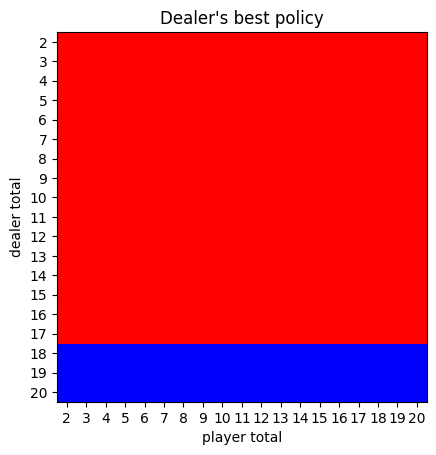

In [ ]:
def classic_dealer_policy():
  policy = dict()
  for i in range(2,21):
      for j in range(2,21):
          if j > 17:
              policy[((i,j), True)] = "HOLD"
              policy[((i,j), False)] = "HOLD"
          else:
              if j >= 11:
                policy[((i,j), True)] = "HIT"
                policy[((i,j), False)] = "HIT"
              else:
                policy[((i,j), False)] = "HIT"
  return policy


visualize_dealer_policy(classic_dealer_policy())

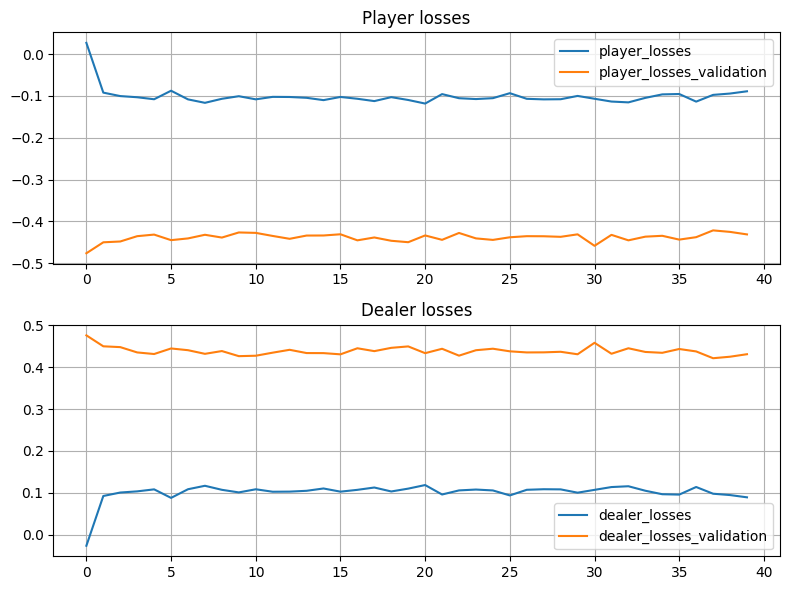

In [ ]:
deck = CardDeck()
p = Agent()
#d = Agent(policy = classic_dealer_policy())
d = Agent()
env = Environment(0.75, deck, p, d, init_action_player = "RANDOM", init_action_dealer="RANDOM") #ovde obrisati inicijalnu akciju ako zelim da dealer igra po classic politici

p_policy, d_policy = env.naive_monte_carlo(10000, 40)


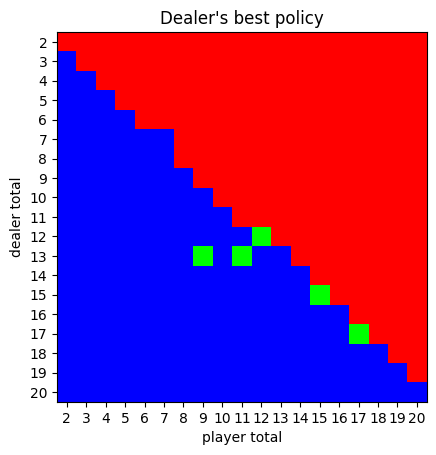

In [ ]:
visualize_dealer_policy(d_policy)

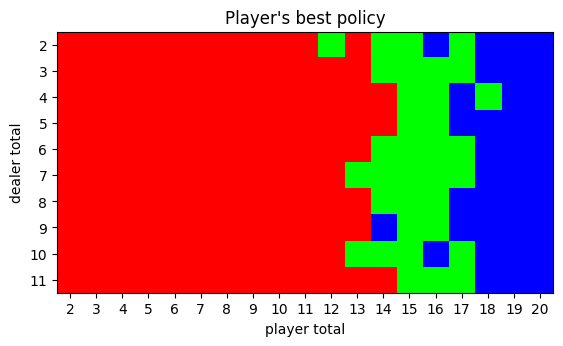

In [ ]:
#print(visualize_policy(classic_dealer_policy()))
visualize_player_policy(p_policy)
#print(env.player_experience[((3,2), False)])
#print(env.Q_player[((3,2), False)])
#print(env.player.policy[((3,2), False)])
#print(max(env.Q_player[((3,2), False)]))
#print(p_policy[((3,2), False)])

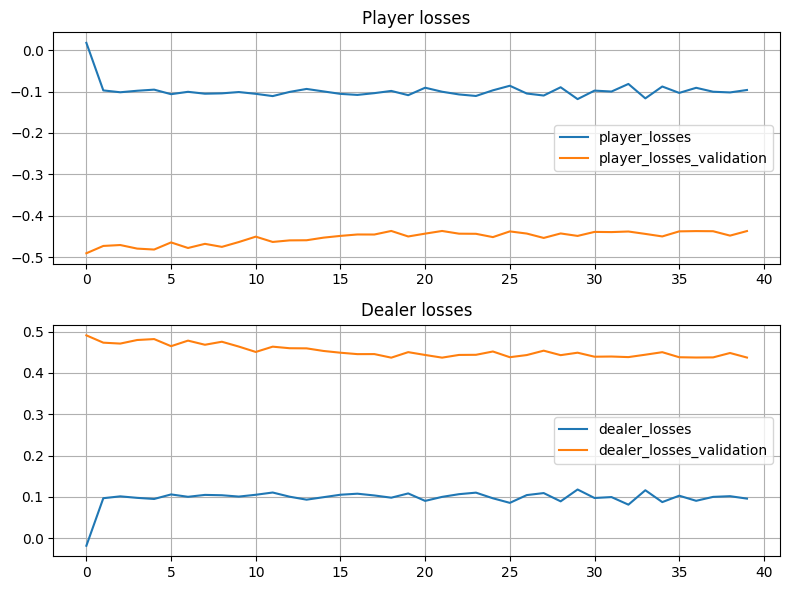

In [ ]:
deck = CardDeck()
p = Agent()
#d = Agent(policy = classic_dealer_policy())
d = Agent()
env = Environment(0.75, deck, p, d, init_action_player = "RANDOM", init_action_dealer="RANDOM") #ovde obrisati inicijalnu akciju ako zelim da dealer igra po classic politici
p_policy, d_policy = env.incremental_monte_carlo(10000, 40)

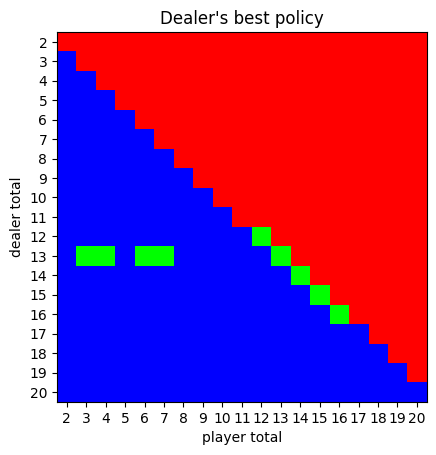

In [ ]:
visualize_dealer_policy(d_policy)

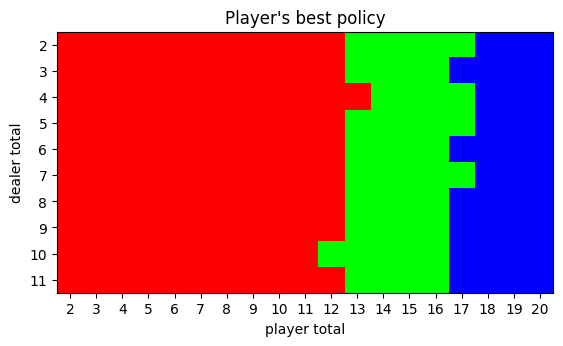

In [ ]:
visualize_player_policy(p_policy)

In [49]:
deck = CardDeck()
p = Agent()
#d = Agent(policy = classic_dealer_policy())
d = Agent()
env = Environment(0.75, deck, p, d, init_action_player = "RANDOM", init_action_dealer="RANDOM") #ovde obrisati inicijalnu akciju ako zelim da dealer igra po classic politici
p_policy, d_policy = env.Q_learning(400000, 0.75, 0.1, 0.4)

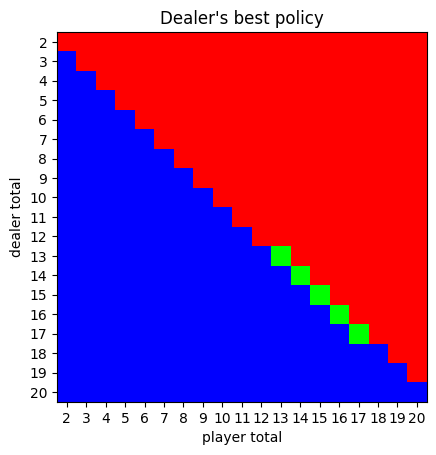

In [50]:
visualize_dealer_policy(d_policy)

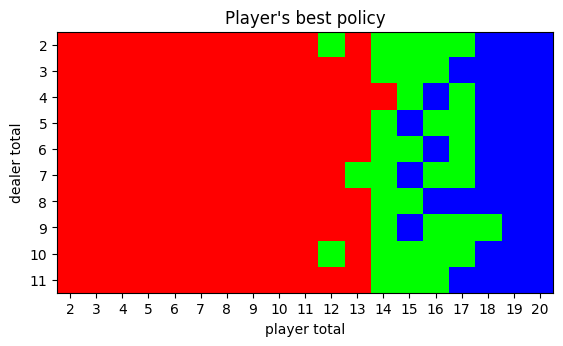

In [51]:
visualize_player_policy(p_policy)

In [54]:
deck = CardDeck()
p = Agent()
#d = Agent(policy = classic_dealer_policy())
d = Agent()
env = Environment(0.75, deck, p, d, init_action_player = "RANDOM", init_action_dealer="RANDOM") #ovde obrisati inicijalnu akciju ako zelim da dealer igra po classic politici
p_policy, d_policy = env.sarsa(400000, 0.75, 0.1, 0.4)

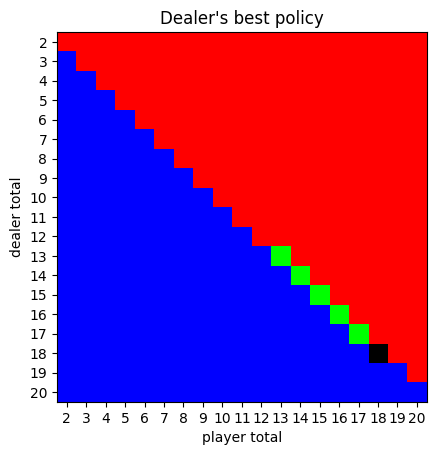

In [55]:
visualize_dealer_policy(d_policy)

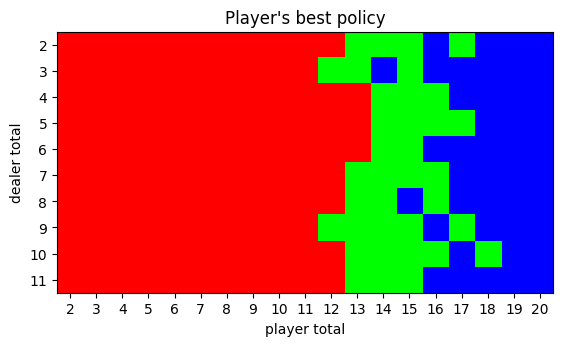

In [56]:
visualize_player_policy(p_policy)